In [4]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [5]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
df = pd.read_csv('/content/train.csv');

In [7]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [9]:
# NLP
from tensorflow.keras.layers import TextVectorization

In [10]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [11]:
df['comment_text']

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [12]:
# Tokenizing - Each word in a sentence in to unique identifier so each word maps to a number
# Like I to 43 etc..
# Has all comments
X = df['comment_text']
# Everthing after column 2 , a file format that can pass to tf model , This is all values converted to vector
y = df[df.columns[2:]].values
MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')
# X.values are coverted to array by numpy internally
vectorizer.adapt(X.values)
vectorized_text = vectorizer(X.values)

In [13]:
vectorizer('Hello I am Farheen')[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([288,   8,  74,   1])>

In [14]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

In [15]:
df.iloc[7]['comment_text']

"Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned."

In [16]:
# Grabbing a row from column 2
df[df.columns[2:]].iloc[5]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 5, dtype: int64

In [17]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps prevents bottlenecks

In [18]:
batch_X , batch_y = dataset.as_numpy_iterator().next()

In [19]:
batch_y.shape

(16, 6)

In [20]:
batch_X.shape

(16, 1800)

In [21]:
len(dataset)*.7

6981.799999999999

In [22]:
# data pipeline dividing in to traiing , validation and test data
train = dataset.take(int(len(dataset)*.7))
# skipping 70% and grabbing 20%
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
# skipping 90% and grabbing 10%
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [23]:
len(test)

997

In [24]:
train_generator = train.as_numpy_iterator().next()

In [25]:
train_generator

(array([[  276,    14,    80, ...,     0,     0,     0],
        [   23,   356,   346, ...,     0,     0,     0],
        [    8,    67, 11163, ...,     0,     0,     0],
        ...,
        [   14,    28,    44, ...,     0,     0,     0],
        [ 1514,  1083,   844, ...,     0,     0,     0],
        [  843,   383,    62, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

Create A Sequential Model - Build the deep neural network

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [27]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))

# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

<Figure size 800x500 with 0 Axes>

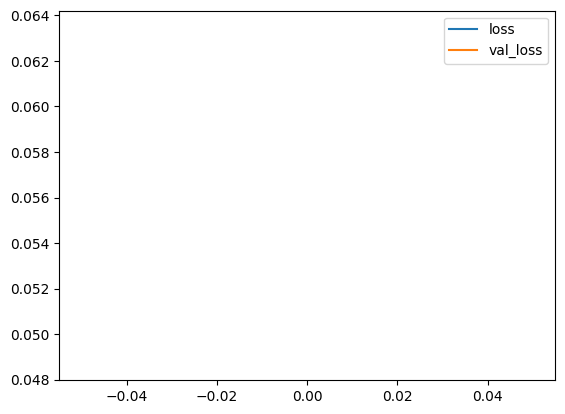

In [28]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()
history = model.fit(train, epochs=1, validation_data=val)
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [29]:
history.history

{'loss': [0.06347166746854782], 'val_loss': [0.048707231879234314]}

<Figure size 800x500 with 0 Axes>

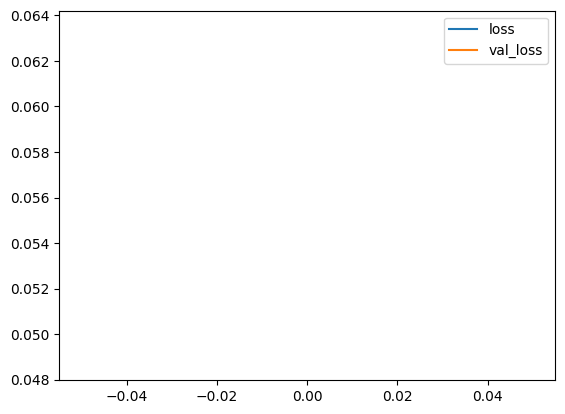

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

Make Predictions

In [36]:
batch = test.as_numpy_iterator().next()


In [38]:
input_text = vectorizer('You freaking suck!')

In [41]:
model.predict(np.array([input_text]))

1/1 [==============================] - 0s 63ms/step


array([[0.9902874 , 0.23834501, 0.9021355 , 0.03454767, 0.7226772 ,
        0.18098822]], dtype=float32)

In [42]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [46]:
res = model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 0s 64ms/step


In [47]:
(res > 0.5).astype(int)
batch_X, batch_y = test.as_numpy_iterator().next()

In [48]:
res = model.predict(np.expand_dims(input_text,0))
(model.predict(batch_X) > 0.5).astype(int)
res.shape

1/1 [==============================] - 0s 66ms/step


(1, 6)

Evaluate the Model

In [49]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test.as_numpy_iterator():
    # Unpack the batch
    X_true, y_true = batch
    # Make a prediction
    yhat = model.predict(X_true)

    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()

    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

1/1 [==============================] - 0s 59ms/step
Precision: 0.8050466775894165, Recall:0.6996095180511475, Accuracy:0.46238717436790466


Test with Gradio

In [53]:
!pip install gradio jinja2

In [54]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)

    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)

    return text

In [ ]:
import tensorflow as tf
import gradio as gr

model.save('toxicity.h5')
model = tf.keras.models.load_model('toxicity.h5')
input_str = vectorizer('hey i freaken hate you!')

res = model.predict(np.expand_dims(input_str,0))




In [58]:
res

array([[0.6653305 , 0.01250034, 0.21694654, 0.0099304 , 0.20860119,
        0.06428357]], dtype=float32)

In [61]:
gr

<module 'gradio' from '/usr/local/lib/python3.10/dist-packages/gradio/__init__.py'>

In [69]:
import gradio as gr


demo = gr.Interface(fn=score_comment, inputs="text", outputs="text")
demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://debc4cae83290afb42.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
